In [5]:
import csv, cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('./data/driving_log.csv', header=0)

In [3]:
data[:3]

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011


In [ ]:
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        steering_center = float(row[3])

        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # read in images from center, left and right cameras
        path = "./data/IMG/" # fill in the path to your training IMG directory
        img_center = process_image(np.asarray(Image.open(path + row[0])))
        img_left = process_image(np.asarray(Image.open(path + row[1])))
        img_right = process_image(np.asarray(Image.open(path + row[2])))

        # add images and angles to data set
        car_images.extend(img_center, img_left, img_right)
        steering_angles.extend(steering_center, steering_left, steering_right)

In [6]:
from sklearn.model_selection import train_test_split

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [34]:
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    batch_size = batch_size
    while 1:  # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for sample in batch_samples:
                file_path = './data/IMG/' + sample[0].split('/')[-1]
                center_image = cv2.imread(file_path)
                center_angle = float(sample[3])
                images.append(center_image)
                angles.append(center_angle)
#                 image_flipped = np.fliplr(center_image)
#                 angle_flipped = - center_angle
#                 images.append(image_flipped)
#                 angles.append(angle_flipped)
                
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [4]:
images = []
measurements = []
for line in lines[1:]:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path = './data/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image)
        measurement = float(line[3])
        correction = 0.25
        if i == 1:
            # left
            measurement = measurement + correction
        elif i == 2:
            # right
            measurement = measurement - correction
        else:
            pass            
        measurements.append(measurement)
        # Data augmentation with image flip
        image_flipped = np.fliplr(image)
        images.append(image_flipped)
        measurement_flipped = -measurement
        measurements.append(measurement_flipped)

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, Cropping2D

Using TensorFlow backend.


In [9]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1,1), 
                 padding='same', activation='relu'))
model.add(Conv2D(6, kernel_size=(3, 3), strides=(2,2), 
                 padding='same', activation='relu'))
model.add(Conv2D(16, kernel_size=(3, 3), strides=(2,2), 
                 padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(1))

In [10]:
model.compile(loss='mse', optimizer='adam')

In [26]:
epochs = 5
batch_size = 32
train_steps = len(train_samples)/batch_size * 3
validation_steps = len(validation_samples)/batch_size * 3

In [35]:
history = model.fit_generator(train_generator, validation_data=validation_generator,
                              steps_per_epoch=train_steps,
                              validation_steps=validation_steps,
                              epochs=epochs)

Epoch 1/5
  3/602 [..............................] - ETA: 327s - loss: 0.0028

KeyboardInterrupt: 

dict_keys(['loss', 'val_loss'])


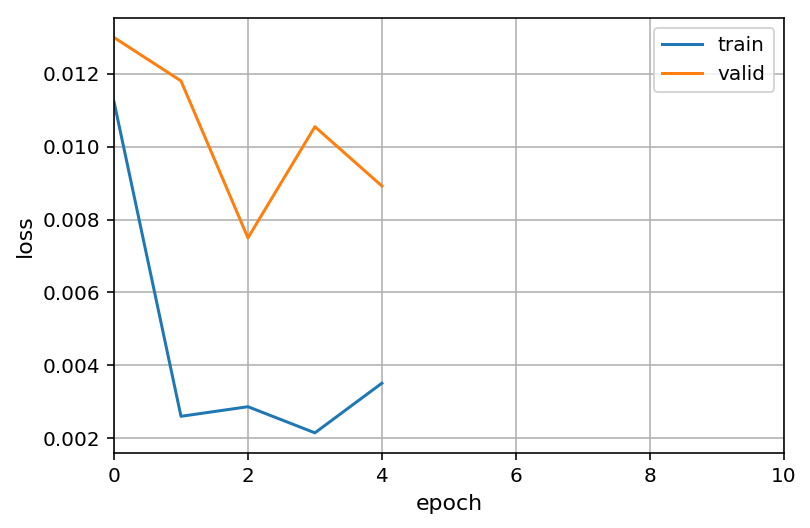

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['train', 'valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
# plt.savefig(img_dir + "/base_loss.png", dpi=300)
plt.show()

In [23]:
model.save('model.h5')